# Lung Cancer Detection

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Input,BatchNormalization
from sklearn import metrics
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import gc
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
from PIL import Image
from glob import glob

## Unzip the Dataset

In [6]:
from zipfile import ZipFile
 
data_path = 'lung_colon_dataset.zip'
 
with ZipFile(data_path,'r') as zip:
  zip.extractall()

## List the total classes of dataset

In [7]:
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_n', 'lung_scc']

## Visualizing images of each class

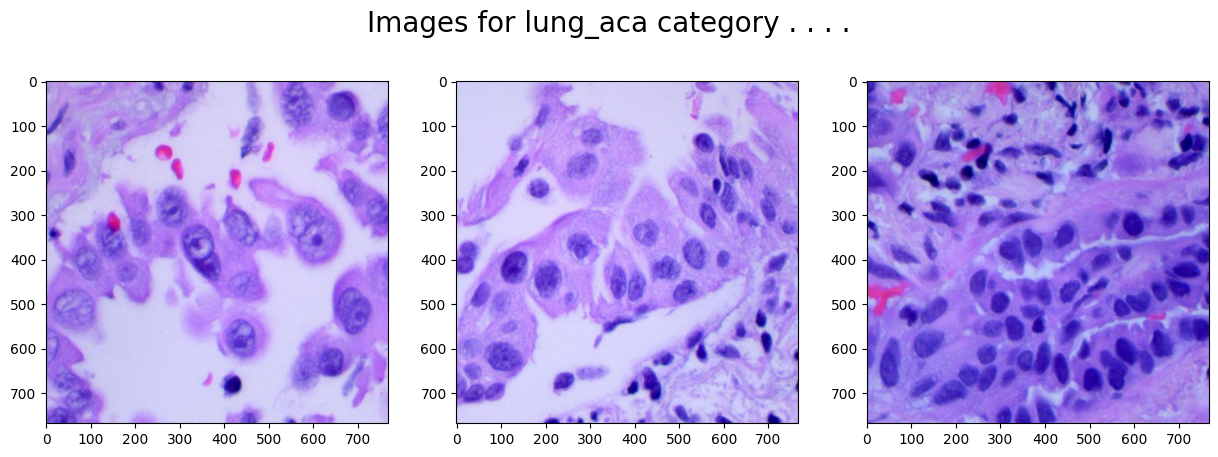

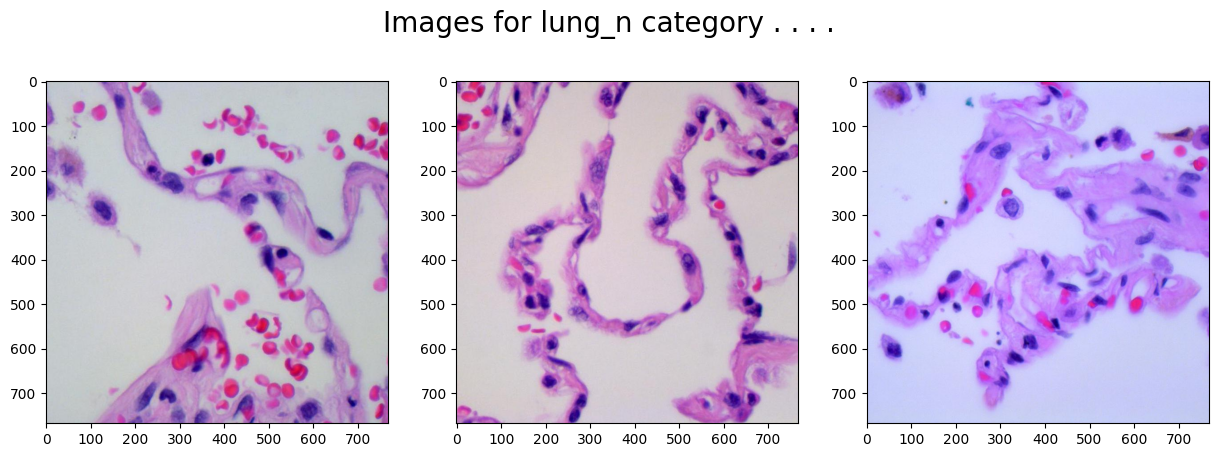

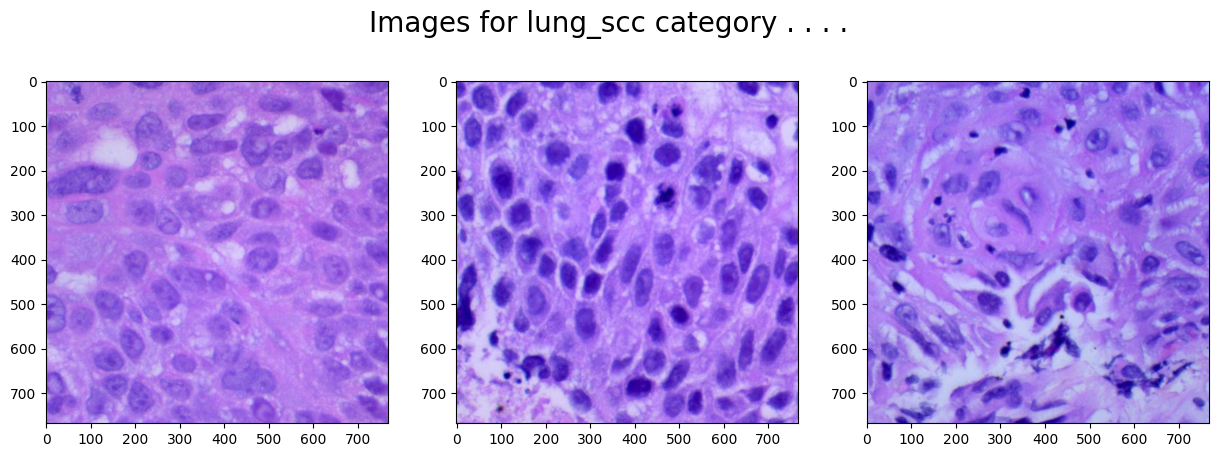

In [8]:
for cat in classes:
    img_dir = f'{path}/{cat}'
    images = os.listdir(img_dir)

    fig,ax = plt.subplots(1,3,figsize=(15,5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    for i in range(0,3):
        k = np.random.randint(0,len(images))
        img = mpimg.imread(f'{path}/{cat}/{images[k]}')
        ax[i].imshow(img)
        # ax[i].axis('off')
    plt.show()

## Resizing images to the required value

In [9]:
X=[]
y=[]

for i,cat in enumerate(classes):
    img_dir = glob(f'{path}/{cat}/*.jpeg')
    for img in img_dir:
        image = cv2.imread(img)
        X.append(cv2.resize(image,(256,256)))
        y.append(i)

X = np.asarray(X)
y = pd.get_dummies(y).values

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size = 0.2,random_state = 100)

In [11]:
print(X_train)

[[[[216 207 220]
   [214 205 218]
   [215 206 219]
   ...
   [190 161 200]
   [199 162 202]
   [215 156 194]]

  [[216 209 222]
   [212 205 218]
   [211 204 217]
   ...
   [191 167 197]
   [197 166 205]
   [210 158 205]]

  [[211 207 219]
   [210 206 218]
   [212 208 220]
   ...
   [200 177 199]
   [194 172 207]
   [198 156 211]]

  ...

  [[205 194 220]
   [204 191 217]
   [205 185 214]
   ...
   [190 121 171]
   [204 136 183]
   [210 145 190]]

  [[207 195 217]
   [204 195 216]
   [202 190 212]
   ...
   [207 155 195]
   [207 163 199]
   [209 168 200]]

  [[209 197 215]
   [206 198 215]
   [204 195 215]
   ...
   [208 172 208]
   [202 176 206]
   [202 180 208]]]


 [[[255 129 188]
   [253 124 191]
   [246 121 191]
   ...
   [234 116 167]
   [237 119 170]
   [240 125 175]]

  [[248 128 186]
   [249 127 191]
   [246 123 189]
   ...
   [238 122 169]
   [235 118 167]
   [239 124 174]]

  [[240 128 186]
   [243 129 189]
   [245 127 186]
   ...
   [235 120 164]
   [239 123 170]
   [237 122

In [12]:
print(y_train)

[[False  True False]
 [False False  True]
 [ True False False]
 ...
 [False False  True]
 [False  True False]
 [False  True False]]


In [13]:
print(X_train.shape,X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


## Using EfficientNetV2S for Transfer learning

In [14]:
efnet = keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3)
)

In [15]:
efnet.trainable=False

In [16]:
print(len(efnet.layers))

513


In [17]:
print('last layer output shape: ', efnet.layers[-1].output )

last layer output shape:  <KerasTensor shape=(None, 8, 8, 1280), dtype=float32, sparse=False, name=keras_tensor_512>


In [18]:
last_output = efnet.layers[-1].output

### Building our custom Fully Connected layer on top of model's Convolution layers

In [19]:
x = layers.Flatten()(last_output)
x = layers.Dense(256,activation='relu')(x) 
x = layers.BatchNormalization()(x) 
x = layers.Dense(128,activation='relu')(x) 
x = layers.Dropout(0.3)(x) 
x = layers.BatchNormalization()(x) 
output = layers.Dense(3,activation='softmax')(x)

In [20]:
model = keras.Model(efnet.input,output)

In [21]:
model.compile( 
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'] 
) 

In [25]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau 
  
class myCallback(tf.keras.callbacks.Callback): 
  def on_epoch_end(self, epoch, logs = {}): 
    if logs.get('val_accuracy') > 0.98: 
      print('\n Validation accuracy has reached upto 98%\ so, stopping further training.') 
      self.model.stop_training = True
  
es = EarlyStopping(patience = 3, 
                   monitor = 'val_accuracy', 
                   restore_best_weights = True) 

## Training the model

In [26]:
history = model.fit(
    X_train,y_train,
    validation_data=(X_val,y_val),
    batch_size=64,
    epochs=15,
    callbacks = [es,myCallback()]
)

Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9824 - loss: 0.0513
 Validation accuracy has reached upto 98%\ so, stopping further training.
188/188 ━━━━━━━━━━━━━━━━━━━━ 1617s 9s/step - accuracy: 0.9824 - loss: 0.0513 - val_accuracy: 0.9870 - val_loss: 0.0337


In [35]:
y_pred = model.predict(X_val) 
  
y_val = np.argmax(y_val) 
y_pred = np.argmax(y_pred)

94/94 ━━━━━━━━━━━━━━━━━━━━ 503s 5s/step


In [36]:
metrics.confusion_matrix(y_val,y_pred)

InvalidParameterError: The 'y_true' parameter of confusion_matrix must be an array-like. Got 0 instead.

In [ ]:
print(metrics.classification_report(y_val, y_pred,target_names=classes))